In [2]:
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from joblib import Parallel, delayed
%matplotlib inline
import os
import subprocess
import time
from joblib import Parallel, delayed
from collections import Counter
from Bio import Entrez
Entrez.email = 'liaochen1988@gmail.com'
from Bio import SeqIO

# Filter HMP data

## taxonomy

In [3]:
df_tax = pd.read_csv('../../databases/HMPv35/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
new_taxon = []
taxon_label = ['k','p','c','o','f','g','s']
for t1 in df_tax['Taxon']:
    curr_taxon = []
    for i, t2 in enumerate(t1.split(';')):
        curr_taxon.append(taxon_label[i]+'__'+t2)
    new_taxon.append((';').join(curr_taxon))
df_tax['Taxon'] = new_taxon
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax['Genus'] = [t.split('g__')[1].split('_')[0].split('-')[0].split(';')[0] if 'g__' in t else 'unclassified' for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy,Genus
0,9f0b677374166540a820720de4b5c497,k__Bacteria;p__Actinobacteriota;c__Actinobacte...,0.999997,g__Cutibacterium,Cutibacterium
1,289741fd8c1b48bfc357686cdb16fb1d,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.999985,g__Streptococcus,Streptococcus
2,b2c534e7cecc5f7533915c3ef4f14c22,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.999970,g__Streptococcus,Streptococcus
3,af972eec0b31108567dc3ceaacbcb05d,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,1.000000,g__Streptococcus,Streptococcus
4,22958f3bf8531f673abde4fba80641ae,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.999945,g__Neisseria,Neisseria


## metadata

In [3]:
df_meta = pd.read_csv("../../databases/HMPv35/metadata.txt", sep="\t", index_col=0)
df_meta['host_visit_id'] = [str(x)+'_'+str(y) for x,y in zip(df_meta.host_subject_id, df_meta.visit_no)]
df_meta = df_meta[df_meta.env.isin(['gastrointestinal_tract','oral_cavity'])]
df_meta.head()

,env,body_site,env_material,psn,sequence_center,host_subject_id,biosample_accession,visit_no,gender,host_visit_id
sample_id,,,,,,,,,,
SRS021079,oral_cavity,hard_palate,sebum,700096626,JCVI,160866180,SAMN00042297,1.0,Female,160866180_1.0
SRS023256,oral_cavity,hard_palate,sebum,700099414,JCVI,964271349,SAMN00044474,NaN,NaN,964271349_nan
SRS050571,oral_cavity,attached keratinized_gingiva,sebum,700108876,BCM,160603188,SAMN00070580,2.0,Male,160603188_2.0
SRS065236,oral_cavity,subgingival_plaque,organic material,700113523,WUGSC,763719065,SAMN00084260,2.0,Female,763719065_2.0
SRS057300,oral_cavity,buccal_mucosa,sebum,700038771,WUGSC,508703490,SAMN00077309,1.0,Female,508703490_1.0


## count data

In [4]:
df_count = pd.read_csv('../../databases/HMPv35/feature_table.txt', sep="\t", index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
print("maximum total count = %d" % df_count.sum(axis=1).max())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1009
maximum total count = 70943


#OTU ID,9f0b677374166540a820720de4b5c497,289741fd8c1b48bfc357686cdb16fb1d,b2c534e7cecc5f7533915c3ef4f14c22,af972eec0b31108567dc3ceaacbcb05d,22958f3bf8531f673abde4fba80641ae,43d63e540470fb5bfbe3fd4cb1f9cecf,47c6886e2a9b01dba19ed501877f3275,ad070cf8732b1266da50e879f4b385c1,299c141b8b33629bbf60b183b0185285,b26c46a877e7a7644e295a5d4dc5f053,...,3a1d415cc5320bfb405c681a7f65b96c,b8c305118313f632b3e4d0c675e572a1,a6549becdc7ee00d9760f7ea6b45fe7b,01f578a47fcdfd2fa45eeccf81807ca8,1fafb1a6a0f8f00dad6a46894c7b7655,31aca8d04471a59da24100ad2691b45c,df31f76f9fb977c81601b002aeaccee5,799e3b7aac70efad46a6b18522707d09,6110793b9360904298285d0ef873c788,822dc6489cee23ca376c8398df0093ab
SRS044548,0.000000,0.000000,0.000000,0.023941,0.001105,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS062615,0.000000,0.000000,0.043224,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS020145,0.000000,0.000000,0.016808,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS011667,0.005037,0.489431,0.051992,0.015472,0.010255,0.005757,0.0,0.00045,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS064076,0.000000,0.000000,0.072059,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## plot oral ASVs in relative abundance-prevalence space

In [5]:
df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))]
df_oral_prevalence = (df_oral_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Oral'}, axis=1)
df_oral = pd.merge(df_oral_mean_relabun, df_oral_prevalence, left_index=True, right_index=True, how='inner')

df_gut_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))].mean().to_frame().rename({0:'MeanRelabun_Gut'}, axis=1)
df_gut_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))]
df_gut_prevalence = (df_gut_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Gut'}, axis=1)
df_gut = pd.merge(df_gut_mean_relabun, df_gut_prevalence, left_index=True, right_index=True, how='inner')

df = pd.merge(df_oral, df_gut, left_index=True, right_index=True, how='left').fillna(0)
num_oral_asvs = len(df)
relabun_cutoff = 1e-4
prevalence_cutoff = 0.05
df['Is_Oral'] = False
df.loc[(df.MeanRelabun_Oral > relabun_cutoff) & (df.Prevalence_Oral > prevalence_cutoff) & (df.MeanRelabun_Gut <= relabun_cutoff) & (df.Prevalence_Gut <= prevalence_cutoff), 'Is_Oral'] = True
filtered_oral_asvs = list(df[df.Is_Oral==True].index)
print("total ASVs in oral cavity = %d, number of oral ASVs = %d" % (num_oral_asvs, len(filtered_oral_asvs)))

df.head()

total ASVs in oral cavity = 23411, number of oral ASVs = 178


,MeanRelabun_Oral,Prevalence_Oral,MeanRelabun_Gut,Prevalence_Gut,Is_Oral
#OTU ID,,,,,
9f0b677374166540a820720de4b5c497,0.000272,0.041651,0.003310,0.006873,False
289741fd8c1b48bfc357686cdb16fb1d,0.066053,0.550170,0.000006,0.000000,True
b2c534e7cecc5f7533915c3ef4f14c22,0.060693,0.474441,0.000012,0.006873,True
af972eec0b31108567dc3ceaacbcb05d,0.032858,0.603559,0.000087,0.044674,True
22958f3bf8531f673abde4fba80641ae,0.031627,0.589171,0.000000,0.000000,True


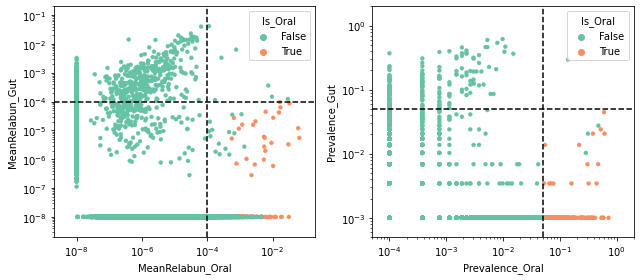

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

df2plot = deepcopy(df)
df2plot.loc[df2plot.MeanRelabun_Gut==0.0, 'MeanRelabun_Gut'] = 1e-8
df2plot.loc[df2plot.MeanRelabun_Oral==0.0, 'MeanRelabun_Oral'] = 1e-8
df2plot.loc[df2plot.Prevalence_Gut==0.0, 'Prevalence_Gut'] = 1e-3
df2plot.loc[df2plot.Prevalence_Oral==0.0, 'Prevalence_Oral'] = 1e-4

# mean relative abundance
_ = sns.scatterplot(x='MeanRelabun_Oral', y='MeanRelabun_Gut', data=df2plot, ax=ax[0], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[0].set_xscale('log')
_ = ax[0].set_yscale('log')
_ = ax[0].set_xlim([2e-9,2e-1])
_ = ax[0].set_ylim([2e-9,2e-1])
_ = ax[0].set_xticks([1e-8,1e-6,1e-4,1e-2])
_ = ax[0].plot([2e-9,2e-1],[relabun_cutoff, relabun_cutoff], 'k--')
_ = ax[0].plot([relabun_cutoff, relabun_cutoff], [2e-9,8e-1], 'k--')

# prevalence
_ = sns.scatterplot(x='Prevalence_Oral', y='Prevalence_Gut', data=df2plot, ax=ax[1], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[1].set_xscale('log')
_ = ax[1].set_yscale('log')
_ = ax[1].set_xlim([5e-5,2])
_ = ax[1].set_ylim([5e-4,2])
_ = ax[1].plot([5e-5,2],[prevalence_cutoff, prevalence_cutoff], 'k--')
_ = ax[1].plot([prevalence_cutoff, prevalence_cutoff], [5e-4,2], 'k--')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("HMP_abundance_prevalence.svg", dpi=600, bbox_inches='tight')

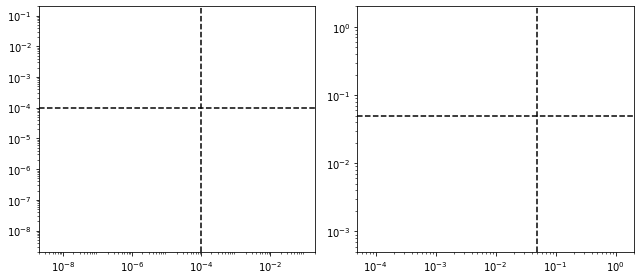

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

df2plot = deepcopy(df)
df2plot.loc[df2plot.MeanRelabun_Gut==0.0, 'MeanRelabun_Gut'] = 1e-8
df2plot.loc[df2plot.MeanRelabun_Oral==0.0, 'MeanRelabun_Oral'] = 1e-8
df2plot.loc[df2plot.Prevalence_Gut==0.0, 'Prevalence_Gut'] = 1e-3
df2plot.loc[df2plot.Prevalence_Oral==0.0, 'Prevalence_Oral'] = 1e-4

# mean relative abundance
#_ = sns.scatterplot(x='MeanRelabun_Oral', y='MeanRelabun_Gut', data=df2plot, ax=ax[0], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[0].set_xscale('log')
_ = ax[0].set_yscale('log')
_ = ax[0].set_xlim([2e-9,2e-1])
_ = ax[0].set_ylim([2e-9,2e-1])
_ = ax[0].set_xticks([1e-8,1e-6,1e-4,1e-2])
_ = ax[0].plot([2e-9,2e-1],[relabun_cutoff, relabun_cutoff], 'k--')
_ = ax[0].plot([relabun_cutoff, relabun_cutoff], [2e-9,8e-1], 'k--')

# prevalence
#_ = sns.scatterplot(x='Prevalence_Oral', y='Prevalence_Gut', data=df2plot, ax=ax[1], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[1].set_xscale('log')
_ = ax[1].set_yscale('log')
_ = ax[1].set_xlim([5e-5,2])
_ = ax[1].set_ylim([5e-4,2])
_ = ax[1].plot([5e-5,2],[prevalence_cutoff, prevalence_cutoff], 'k--')
_ = ax[1].plot([prevalence_cutoff, prevalence_cutoff], [5e-4,2], 'k--')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("HMP_abundance_prevalence_frames.svg", dpi=600, bbox_inches='tight')

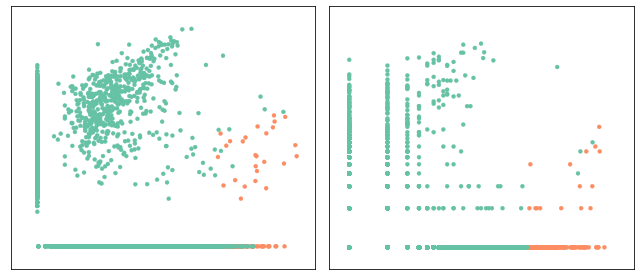

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

df2plot = deepcopy(df)
df2plot.loc[df2plot.MeanRelabun_Gut==0.0, 'MeanRelabun_Gut'] = 1e-8
df2plot.loc[df2plot.MeanRelabun_Oral==0.0, 'MeanRelabun_Oral'] = 1e-8
df2plot.loc[df2plot.Prevalence_Gut==0.0, 'Prevalence_Gut'] = 1e-3
df2plot.loc[df2plot.Prevalence_Oral==0.0, 'Prevalence_Oral'] = 1e-4

# mean relative abundance
_ = sns.scatterplot(x='MeanRelabun_Oral', y='MeanRelabun_Gut', data=df2plot, ax=ax[0], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[0].set_xscale('log')
_ = ax[0].set_yscale('log')
_ = ax[0].set_xlim([2e-9,2e-1])
_ = ax[0].set_ylim([2e-9,2e-1])
_ = ax[0].get_legend().remove()
_ = ax[0].set_xlabel('')
_ = ax[0].set_ylabel('')
_ = ax[0].get_xaxis().set_visible(False)
_ = ax[0].get_yaxis().set_visible(False)

# prevalence
_ = sns.scatterplot(x='Prevalence_Oral', y='Prevalence_Gut', data=df2plot, ax=ax[1], hue='Is_Oral', palette='Set2', edgecolor=None, s=16)
_ = ax[1].set_xscale('log')
_ = ax[1].set_yscale('log')
_ = ax[1].set_xlim([5e-5,2])
_ = ax[1].set_ylim([5e-4,2])
_ = ax[1].get_legend().remove()
_ = ax[1].set_xlabel('')
_ = ax[1].set_ylabel('')
_ = ax[1].get_xaxis().set_visible(False)
_ = ax[1].get_yaxis().set_visible(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("HMP_abundance_prevalence_no_annotation.png", dpi=600, bbox_inches='tight')

# Test the effects of thresholds

In [136]:
df_all = None
for relabun_cutoff in [1e-4,1e-3]:
    for prevalence_cutoff in [0.05,0.10]:
        for presence_cutoff in [1e-4,1e-3]:
            df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
            df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))]
            df_oral_prevalence = (df_oral_prevalence>presence_cutoff).astype(int).mean().to_frame().rename({0:'Prevalence_Oral'}, axis=1)
            df_oral = pd.merge(df_oral_mean_relabun, df_oral_prevalence, left_index=True, right_index=True, how='inner')

            df_gut_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))].mean().to_frame().rename({0:'MeanRelabun_Gut'}, axis=1)
            df_gut_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))]
            df_gut_prevalence = (df_gut_prevalence>presence_cutoff).astype(int).mean().to_frame().rename({0:'Prevalence_Gut'}, axis=1)
            df_gut = pd.merge(df_gut_mean_relabun, df_gut_prevalence, left_index=True, right_index=True, how='inner')

            df = pd.merge(df_oral, df_gut, left_index=True, right_index=True, how='left').fillna(0)
            num_oral_asvs = len(df)
            df['Is_Oral'] = 0
            df.loc[(df.MeanRelabun_Oral > relabun_cutoff) & (df.Prevalence_Oral > prevalence_cutoff) & (df.MeanRelabun_Gut <= relabun_cutoff) & (df.Prevalence_Gut <= prevalence_cutoff), 'Is_Oral'] = 1
            df = df[df.Is_Oral==1]
            df = df[['Is_Oral']].rename({'Is_Oral':'%2.2e, %2.2e, %2.2e' %(relabun_cutoff, prevalence_cutoff, presence_cutoff)}, axis=1)
            if df_all is None:
                df_all = deepcopy(df)
            else:
                df_all = pd.merge(df_all, df, left_index=True, right_index=True, how='outer').fillna(0)
df_all.head()

,"1.00e-04, 5.00e-02, 1.00e-04","1.00e-04, 5.00e-02, 1.00e-03","1.00e-04, 1.00e-01, 1.00e-04","1.00e-04, 1.00e-01, 1.00e-03","1.00e-03, 5.00e-02, 1.00e-04","1.00e-03, 5.00e-02, 1.00e-03","1.00e-03, 1.00e-01, 1.00e-04","1.00e-03, 1.00e-01, 1.00e-03"
#OTU ID,,,,,,,,
0096a273ac0abbb04557fff40774244c,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0863adf64994d46f2342303cdd22bde9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
08a4d4e95b0f4a7f11cd17b916fc366b,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
0936f17723be73c6e5220d3bb175d53b,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0c26d5527a0f5dd2c2701bb297ac96b9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df_all['1.00e-04, 5.00e-02, 1.00e-03'].sum()

178.0

In [140]:
df_all.to_csv("oral_typical_seqs_vary_cutoffs.csv")

# Get full sequences of oral ASVs

In [10]:
fasta_sequences = SeqIO.parse(open("../../databases/HMPv35/HMPv35.fasta"),'fasta')
HMP_seqs_all = []
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    HMP_seqs_all.append([name, sequence])
df_HMP_seqs_all = pd.DataFrame(HMP_seqs_all, columns=['HMP_SeqID','HMP_Sequence'])
df_HMP_seqs_oral = df_HMP_seqs_all[df_HMP_seqs_all.HMP_SeqID.isin(filtered_oral_asvs)]

# write all oral sequences into a single fasta file
seq_length_dict = {}
with open("../../databases/HMPv35oral/HMPv35oral.fasta", "w") as out_file:
    for name, sequence in zip(df_HMP_seqs_oral.HMP_SeqID, df_HMP_seqs_oral.HMP_Sequence):
        out_file.write(">%s\n%s\n"%(name, sequence))
        seq_length_dict[name] = len(sequence)
        
# # separate the fasta file into multiple trunks 
# fasta_sequences = SeqIO.parse(open("HMPv35oral.fasta"),'fasta')
# local_iter=0
# global_iter=0
# for fasta in fasta_sequences:
#     if local_iter==0:
#         f = open("blast_ungapped_nt/trunk%d.fasta"%global_iter, "w")
#     name, sequence = fasta.id, str(fasta.seq)
#     f.write(">%s\n%s\n"%(name, sequence))
    
#     if local_iter == 10:
#         local_iter=0
#         global_iter+=1
#     else:
#         local_iter += 1
# f.close()

In [11]:
len(seq_length_dict)

178

In [16]:
df2output = pd.merge(df, df_HMP_seqs_oral.set_index('HMP_SeqID'), left_index=True, right_index=True, how='inner').drop('Is_Oral', axis=1)
df2output.index.name = 'ASV'
df2output = pd.merge(df2output, df_tax[['ASV','Taxon','LowestTaxonomy','Genus']].set_index('ASV'), left_index=True, right_index=True, how='inner') 
df2output.to_csv("../../databases/HMPv35oral/HMPv35oral_text.csv")

In [17]:
df2output.head()

,MeanRelabun_Oral,Prevalence_Oral,MeanRelabun_Gut,Prevalence_Gut,HMP_Sequence,Taxon,LowestTaxonomy,Genus
ASV,,,,,,,,
289741fd8c1b48bfc357686cdb16fb1d,0.066053,0.550170,0.000006,0.000000,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,g__Streptococcus,Streptococcus
b2c534e7cecc5f7533915c3ef4f14c22,0.060693,0.474441,0.000012,0.006873,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,g__Streptococcus,Streptococcus
af972eec0b31108567dc3ceaacbcb05d,0.032858,0.603559,0.000087,0.044674,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,g__Streptococcus,Streptococcus
22958f3bf8531f673abde4fba80641ae,0.031627,0.589171,0.000000,0.000000,TTTAATCTTGCGACCGTACTCCCCAGGCGGTCAATTTCACGCGTTA...,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,g__Neisseria,Neisseria
299c141b8b33629bbf60b183b0185285,0.030577,0.231730,0.000003,0.000000,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,g__Streptococcus,Streptococcus


# Taxonomic distribution of oral-typical bacteria

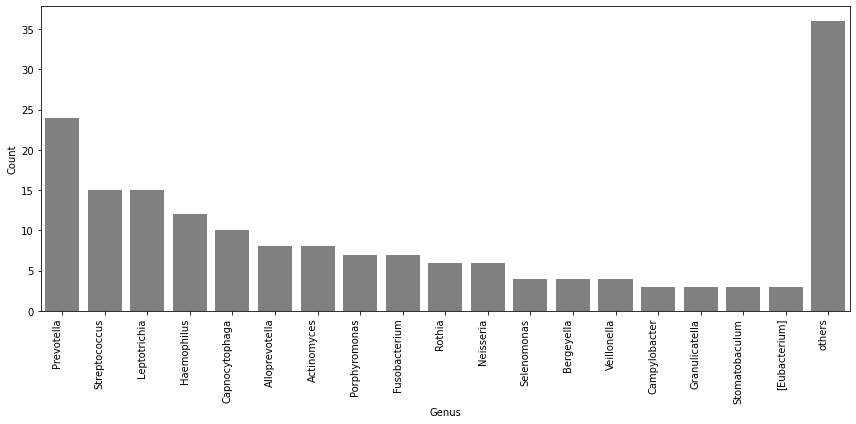

In [104]:
df_tax_oral = df_tax.loc[df_tax.ASV.isin(filtered_oral_asvs), ['Genus']]
#df_tax_oral.loc[df_tax_oral.Genus == 'unclassified', 'Genus'] = 'others'

fig, ax = plt.subplots(figsize=(12,6))

df_stat = pd.DataFrame.from_dict(dict(Counter(df_tax_oral.Genus)), orient="index").sort_values(0, ascending=False).reset_index().rename({'index':'Genus', 0:'Count'}, axis=1)
df_stat2 = df_stat[df_stat.Count>2]
#df_stat2.loc[df_stat2.Genus=='others', 'Count'] += len(df_stat[df_stat.Count<=2])
df_stat2 = pd.concat([df_stat2, pd.DataFrame([['others', df_stat[df_stat.Count<=2].Count.sum()]], columns=['Genus','Count'])])
_ = sns.barplot(x="Genus", y="Count", data=df_stat2, ax=ax, color='gray')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("genera_count_in_HMPv35oral.svg", dpi=600, bbox_inches='tight')

In [105]:
df_stat2.Count.sum()

178

## distribution of Prevotella species

In [78]:
df_tax_oral = df_tax.loc[df_tax.ASV.isin(filtered_oral_asvs), ['Taxon','LowestTaxonomy']]
df_tax_oral = df_tax_oral[df_tax_oral.Taxon.str.contains('g__Prevotella')]
Counter(df_tax_oral.LowestTaxonomy)

Counter({'g__Prevotella_7': 3,
         's__Prevotella-melaninogenica': 1,
         's__Prevotella-histicola': 3,
         's__Prevotella-jejuni': 1,
         's__Prevotella-pallens': 2,
         's__Prevotella-nanceiensis': 1,
         's__Prevotella-nigrescens': 1,
         's__Prevotella-sp.-oral-taxon-299-str.-F0039': 2,
         's__Prevotella-shahii': 1,
         's__Prevotella-salivae': 4,
         's__Prevotella-oris': 2,
         's__Prevotella-intermedia': 1,
         's__Prevotella-loescheii': 1,
         's__Prevotella-sp.-oral-taxon-317-str.-F0108': 1})